<a href="https://colab.research.google.com/github/jlin157/Palladium-price-prediction/blob/main/Palladium_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%pylab inline 
warnings.filterwarnings("ignore")
import seaborn
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [114]:
df_palladium = pd.read_csv(r'palladium-prices-historical-chart-data.csv',index_col=0,parse_dates=True)['1986/1/2':'2021/4/19']
df_palladium.index.names = ['Date']
df_palladium.columns = ['Palladium Index']
df_palladium.head()

,Palladium Index
Date,
1986-01-02,96.00
1986-01-03,96.05
1986-01-06,98.05
1986-01-07,100.50
1986-01-08,101.50


# Correlation Analysis

In [115]:
df_WTI = pd.read_csv(r'DCOILWTICO.csv',index_col=0,parse_dates=True)['1986-01-02':'2021-04-19']
df_WTI.index.names = ['Date']
df_WTI.columns = ['WTI_Crude_Oil_Index']
df_WTI['WTI_Crude_Oil_Index'] = df_WTI['WTI_Crude_Oil_Index'].replace('.', None)
df_WTI['WTI_Crude_Oil_Index'] = df_WTI['WTI_Crude_Oil_Index'].astype(float)

In [116]:
df_pla = pd.read_csv(r'platinum-prices-historical-chart-data.csv',index_col=0,parse_dates=True)['1986/1/2':'2021/4/19']
df_pla.index.names = ['Date']
df_pla.columns = ['Platinum Index']
df_pla['Platinum Index'] = df_pla['Platinum Index'].astype(float)
df_pla.index = pd.to_datetime(df_pla.index)

In [117]:
df_nik = pd.read_excel(r'PNICKUSDM.xls',index_col=0,parse_dates=True)['1986/1/2':'2021/4/19']
df_nik.index.names = ['Date']
df_nik.columns = ['Nickel Index']
#df_nik['Platinum Index'] = df_nik['Platinum Index'].astype(float)
#df_nik.index = pd.to_datetime(df_nik.index)

In [118]:
df_veh=pd.read_excel(r'Motor Vehicle Production.xlsx',index_col=0,parse_dates=True)[::-1]
df_veh.index.names = ['Date']
df_veh.columns = ['World Vechicle Production']
df_veh.index=df_veh.index.strftime('%Y')

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(18,21))
axs[0,0].plot(df_palladium)
axs[0,0].title.set_text('Palladium Index')
axs[0,0].set_xlabel('year')
axs[0,0].set_ylabel('price per ounce')
axs[0,1].plot(df_pla)
axs[0,1].title.set_text('Platinum Index')
axs[0,1].set_xlabel('year')
axs[0,1].set_ylabel('price per ounce')
axs[1,0].plot(df_nik)
axs[1,0].title.set_text('Nickel Index')
axs[1,0].set_xlabel('year')
axs[1,0].set_ylabel('price per tonne')
axs[1,1].plot(df_veh)
axs[1,1].title.set_text('World Vechicle Production')

In [119]:
dfs = pd.merge(df_palladium, df_pla, on="Date")
dfs = pd.merge(dfs, df_nik, on='Date')
precrisis=dfs[:'2008-01-01']
postcrisis=dfs['2008-01-01':]

In [ ]:
corr_df = precrisis.corr(method='pearson')
print(corr_df)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
seaborn.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

In [ ]:
corr_df = postcrisis.corr(method='pearson')
print(corr_df)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
seaborn.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

In [ ]:
df_annualprice=df_palladium.groupby(df_palladium.index.year)['Palladium Index'].transform('mean')
df_annualprice=df_annualprice.to_frame()
df_annualprice.index=df_annualprice.index.strftime('%Y')
df_annualprice=df_annualprice.drop_duplicates()
df_annualprice.head()

In [ ]:
df_vehpalla = pd.merge(df_annualprice, df_veh, on='Date')
corr2_df = df_vehpalla[:'2017'].corr(method='pearson')
print(corr2_df)
mask = np.zeros_like(corr2_df)
mask[np.triu_indices_from(mask)] = True
seaborn.heatmap(corr2_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.title('Correlation pior 2017', color='green',fontsize=14)
plt.show()

In [ ]:
corr2_df = df_vehpalla['2017':].corr(method='pearson')
print(corr2_df)
mask = np.zeros_like(corr2_df)
mask[np.triu_indices_from(mask)] = True
seaborn.heatmap(corr2_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.title('Correlation after 2017', color='red',fontsize=14)
plt.show()

#Segmental Regression

In [106]:
from scipy import optimize
from datetime import date

In [107]:
x=np.array([float(i) for i in df_veh.index])
y=np.array(df_veh['World Vechicle Production'])

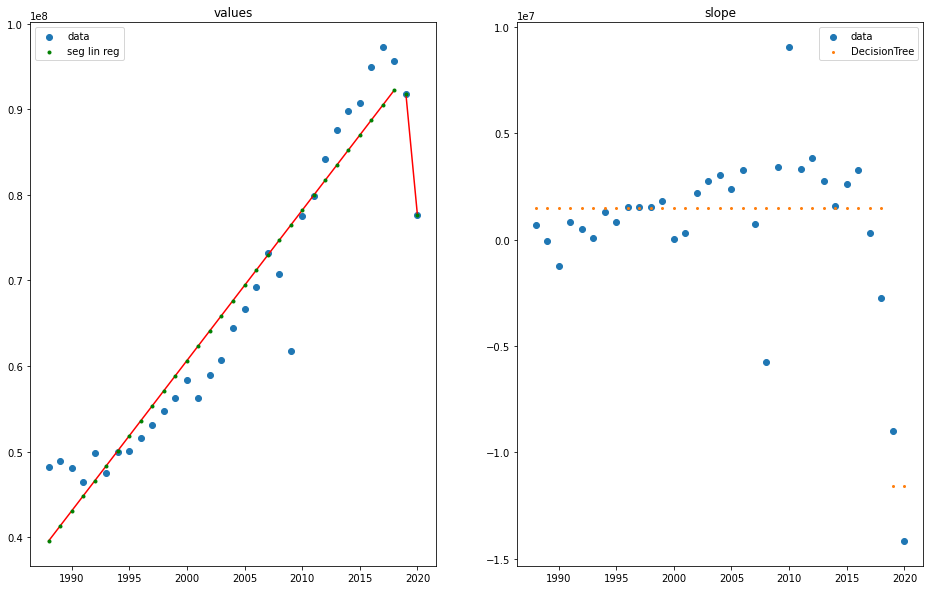

In [108]:
# parameters for setup
n_data = 33

# segmented linear regression parameters
n_seg = 2

np.random.seed(0)
fig, (ax0, ax1) = plt.subplots(1, 2,figsize=(16,10))

ys=y
xs=np.array([int(i) for i in x])

dys = np.gradient(ys, xs)

rgr = DecisionTreeRegressor(max_leaf_nodes=n_seg)
rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()

ys_sl = np.ones(len(xs)) * np.nan
for y in np.unique(dys_dt):
    msk = dys_dt == y
    lin_reg = LinearRegression()
    lin_reg.fit(xs[msk].reshape(-1, 1), ys[msk].reshape(-1, 1))
    ys_sl[msk] = lin_reg.predict(xs[msk].reshape(-1, 1)).flatten()
    ax0.plot([xs[msk][0], xs[msk][-1]],
             [ys_sl[msk][0], ys_sl[msk][-1]],
             color='r', zorder=1)

ax0.set_title('values')
ax0.scatter(xs, ys, label='data')
ax0.scatter(xs, ys_sl, s=3**2, label='seg lin reg', color='g', zorder=5)
ax0.legend()

ax1.set_title('slope')
ax1.scatter(xs, dys, label='data')
ax1.scatter(xs, dys_dt, label='DecisionTree', s=2**2)
ax1.legend()

plt.show()

In [109]:
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

In [111]:
y=np.array(df_annualprice['Palladium Index'][14:-1])
x=np.array(df_veh['World Vechicle Production'][12:])

px, py = segments_fit(x, y, 1) #World Vehicle
print(px,py)

[56304925. 97302534.] [ 329.59043421 1002.19124121]


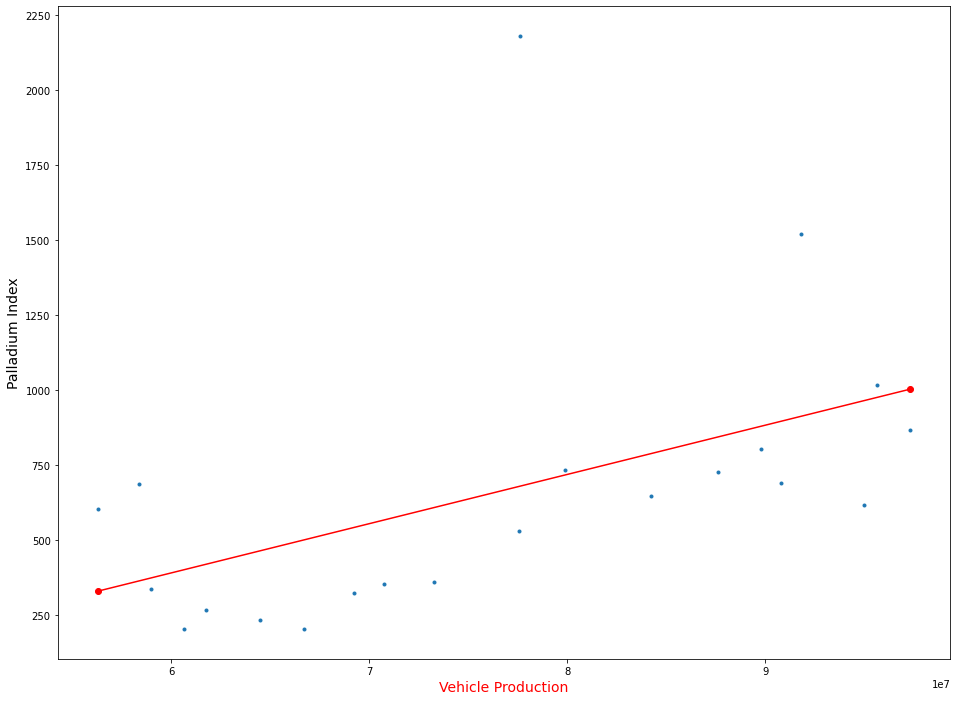

In [112]:
fig,ax = plt.subplots(1,figsize=(16,12))
ax.plot(x, y, ".")
ax.plot(px, py, "-or")
ax.set_ylabel("Palladium Index",fontsize=14)
ax.set_xlabel("Vehicle Production",color="red",fontsize=14)
plt.show()

#LSTM

In [121]:
dataset=df_palladium.values
traininglength=math.ceil(len(dataset)*0.8)

In [122]:
scalar=MinMaxScaler(feature_range=(0,1))
scaled_data=scalar.fit_transform(dataset)

In [123]:
train_data=scaled_data[0:traininglength,:]
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [21]:
x_train,y_train=np.array(x_train),np.array(y_train)

In [22]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape #converted 2D to 3D

(7052, 60, 1)

LSTM

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

model.add(LSTM(50,return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error')

In [24]:
#Train
model.fit(x_train,y_train,batch_size=1,epochs=1)

7052/7052 [==============================] - 189s 26ms/step - loss: 2.4816e-04


In [25]:
#Test
#Create Test Validate set
test_data=scaled_data[traininglength-60:,:]
x_test=[]
y_test=dataset[traininglength:,:]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [26]:
#LSTM only take numpy array
x_test=np.array(x_test)

(1778, 60)

In [27]:
#LSTM expecting 3D 
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

(1778, 60, 1)

In [28]:
predictions=model.predict(x_test)
predictions=scalar.inverse_transform(predictions)

In [29]:
#see how the model performed
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

47.051377309647165

In [30]:
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.9937027706441661

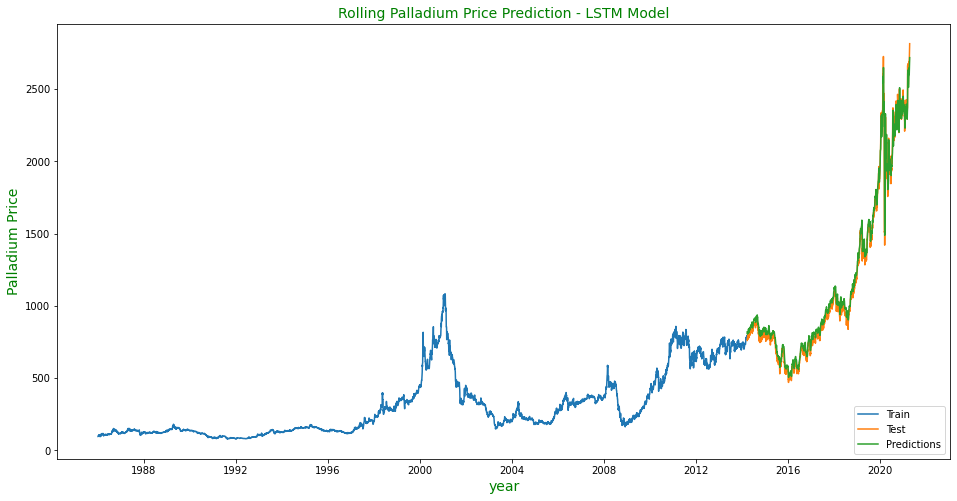

In [31]:
#plot the data
train=df_palladium[:traininglength]
valid=df_palladium[traininglength:]
valid['Predictions']=predictions
plt.figure(figsize=(16,8))
plt.plot(train)
plt.plot(valid)
plt.xlabel("year",color="green",fontsize=14)
plt.ylabel('Palladium Price',color="green",fontsize=14)
plt.title('Rolling Palladium Price Prediction - LSTM Model',color="green",fontsize=14)
plt.legend(['Train','Test','Predictions'],loc='lower right')

Try predict future

In [32]:
#predictions of next 10 days
future_price=[]
for i in range(10):
  x_future=[scaled_data[-60:]]
  x_future=np.array(x_future)
  x_future=np.reshape(x_future,(x_future.shape[0],x_future.shape[1],1))
  
  predictions=model.predict(x_future)
  scaled_data=np.append(scaled_data,[predictions])

  predictions=scalar.inverse_transform(predictions)
  future_price.append(predictions[0][0])

In [33]:
df = pd.DataFrame()
df['future stock']=future_price
df.head()

,future stock
0,2755.169434
1,2737.208252
2,2706.757324
3,2669.445068
4,2628.920166


# Decision Tree and Linear Regression

In [124]:
df=df_palladium

In [125]:
future_day=250
df['Prediction']=df[['Palladium Index']].shift(-future_day)

In [126]:
x=np.array(df.drop(['Prediction'],1))[:-future_day]

In [127]:
y=np.array(df['Prediction'])[:-future_day]

In [128]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20)

In [129]:
tree=DecisionTreeRegressor().fit(x_train,y_train)
linear=LinearRegression().fit(x_train,y_train)
x_future=df.drop(['Prediction'],1)[:-future_day]
x_future=x_future.tail(future_day)
x_future=np.array(x_future)

In [130]:
tree_prediction=tree.predict(x_future)
linear_prediction=linear.predict(x_future)

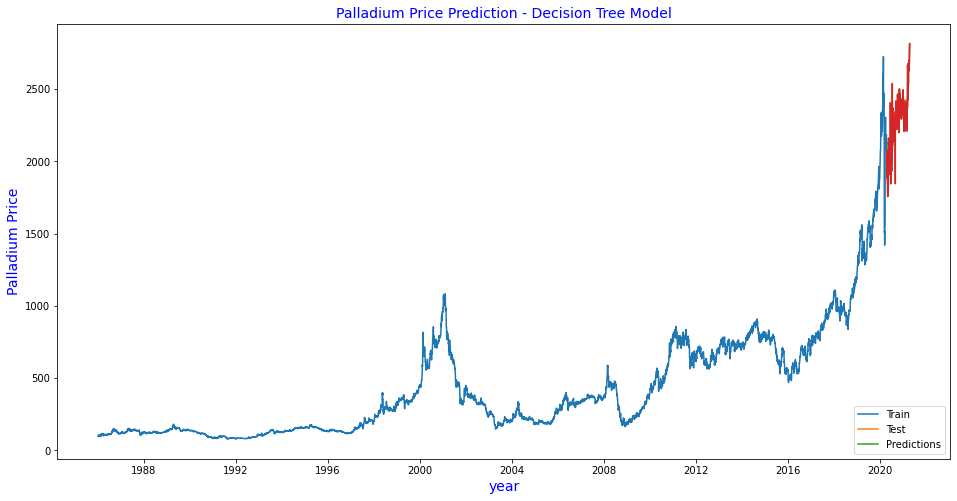

In [131]:
predictions=tree_prediction
valid=df[x.shape[0]:]
valid['Predictions']=predictions
plt.figure(figsize(16,8))
plt.plot(df['Palladium Index'])
plt.plot(valid)
plt.xlabel("year",color="blue",fontsize=14)
plt.ylabel('Palladium Price',color="blue",fontsize=14)
plt.title('Palladium Price Prediction - Decision Tree Model',color="blue",fontsize=14)
plt.legend(['Train','Test','Predictions'],loc='lower right')

In [133]:
#see how the model performed
yy=df['Prediction'][-500:-250]
rmse=np.sqrt(np.mean(((predictions- yy)**2)))
rmse

67.52965798817583

In [134]:
from sklearn.metrics import r2_score
r2_score(yy, predictions)

0.9058711293267944

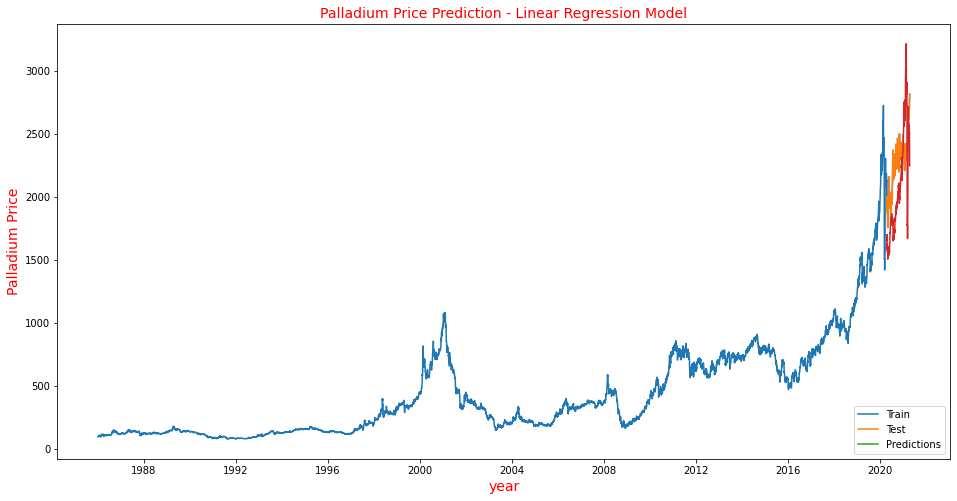

In [135]:
predictions=linear_prediction
valid=df[x.shape[0]:]
valid['Predictions']=predictions
plt.figure(figsize(16,8))
plt.plot(df['Palladium Index'])
plt.plot(valid)
plt.xlabel("year",color="red",fontsize=14)
plt.ylabel('Palladium Price',color="red",fontsize=14)
plt.title('Palladium Price Prediction - Linear Regression Model',color="red",fontsize=14)
plt.legend(['Train','Test','Predictions'],loc='lower right')

In [137]:
yy=df['Prediction'][-500:-250]
#see how the model performed
rmse=np.sqrt(np.mean(((predictions- yy)**2)))
rmse

373.13436099194934

In [138]:
from sklearn.metrics import r2_score
r2_score(yy, predictions)

-1.873850921425677